In [62]:
import datetime
import json
import os
import random
import sys
import warnings
import pandas as pd

sys.path.append(os.path.join(os.getcwd(), '../../common'))
from ppg_feature_processor import generate_train_feature

# Suppress specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*Conversion of an array with ndim > 0 to a scalar is deprecated.*")

In [63]:
## 1)Read the university subjects and find the positive and negative subjects.

In [64]:
# 读取 Excel 文件
middleSchool_userProfile_file = r'../../ppg_depression/data_preprocess/outdir/MiddleSchool_Depression_Anxiety.xlsx'
university_userProfile_file = r'C:\Users\Administrator\Desktop\PPG_dataset\Xinlian_dataset\label\healthy_scale_results.xlsx'
hospital_userProfile_file = '../../../Data/unhealthy_clinic_results.xlsx'


In [65]:
df_university = pd.read_excel(university_userProfile_file, sheet_name='POMS')
selected_columS_POMS = ['ID', '1. Tense','8. Uneasy','15. Restless','21. On-edge','28. Nervous','35. Anxious']
df_university['Total'] = df_university[selected_columS_POMS].drop('ID',axis = 1).sum(axis=1)

university_positive_subjects_POMS = df_university[df_university['Total']>= 15]['ID'].to_list()
university_positive_subjects_POMS = []
print("University Positive stress subjects: ", university_positive_subjects_POMS)

# Select the extrame subject to be the negative.
university_negative_subjects_POMS = df_university[df_university['Total']< 15]['ID'].to_list()
university_negative_subjects_POMS = []
print("University Negative stress subjects: ", university_negative_subjects_POMS)



University Positive stress subjects:  []
University Negative stress subjects:  []


In [66]:
stress_positive_threshold = 6
stress_negative_threshold = 5

In [67]:
### READ THE MIDDLESCHOOL SUBJECTS
df_middle = pd.read_excel(middleSchool_userProfile_file)
df_middle = df_middle[(df_middle['stress_sum'] > stress_positive_threshold) | (df_middle['stress_sum'] < stress_negative_threshold)]
print(f"Midlle schold available subject count: {df_middle.shape}")


middle_pos_subjects = df_middle[df_middle['stress_sum'] > stress_positive_threshold]['user_id'].values.tolist()
middle_neg_subjects = df_middle[df_middle['stress_sum'] < stress_negative_threshold]['user_id'].values.tolist()

print(f"middle stress positive subjects count: {len(middle_pos_subjects)}")
print(f"middle stress negative subjects count: {len(middle_neg_subjects)}")

Midlle schold available subject count: (349, 110)
middle stress positive subjects count: 160
middle stress negative subjects count: 189


In [68]:
profile_dict = dict()

for _, row in df_university.iterrows():
    userId = row['ID']
    gender = 'Male' if row['Sex'] == '男' else 'Female'
    age = row['Age (years)']
    profile_dict[userId] = (gender, age)

for _, row in df_middle.iterrows():
    userId = row['user_id']
    gender = row['gender']
    age = 13
    profile_dict[userId] = (gender, age)

# for key, val in profile_dict.items():
#     print(f"userId: {key}, value: {val}")


In [69]:
random.shuffle(middle_pos_subjects)
random.shuffle(middle_neg_subjects)

test_subject_count = 15
val_subject_count = 10

test_pos_subjects = middle_pos_subjects[0:test_subject_count]
test_neg_subjects = middle_neg_subjects[0:test_subject_count]

val_pos_subjects = middle_pos_subjects[test_subject_count:test_subject_count+val_subject_count]
val_neg_subjects = middle_neg_subjects[test_subject_count:test_subject_count+val_subject_count]

train_pos_subjects = middle_pos_subjects[test_subject_count+val_subject_count::] + university_positive_subjects_POMS
train_neg_subjects = middle_neg_subjects[test_subject_count+val_subject_count::] + university_negative_subjects_POMS

print(f"train postive subjects: {len(train_pos_subjects)}")
print(f"train negative subjects: {len(train_neg_subjects)}")

print(f"validation postive subjects: {len(val_pos_subjects)}")
print(f"validation negative subjects: {len(val_neg_subjects)}")

print(f"test postive subjects: {len(test_pos_subjects)}")
print(f"test negative subjects: {len(test_neg_subjects)}")


train postive subjects: 135
train negative subjects: 164
validation postive subjects: 10
validation negative subjects: 10
test postive subjects: 15
test negative subjects: 15


In [70]:
def load_wave_university_or_hospital(path):
    with open(path, 'r', encoding='utf-8') as file:  
            data = json.load(file)
            list_data = data['MesureData']['Datas']
            final = [i for i in list_data]
            return final

def load_wave_middleSchool(path):
    try:
        with open(path, 'r', encoding='utf-8') as file:  
            data = json.load(file)
            list_data = data['RawResults'][0]['rawDatas']
            final = [i/100000 for i in list_data]
        return final
    except (KeyError, IndexError, TypeError):
        with open(path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data["datas"]


In [71]:
sample_freq = 125
sample_window_minute = 0.5

university_file_dir = r'C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\healthy'
middle_file_dir = r'C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data'
hospital_file_dir = r'C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\unhealthy'

In [72]:
def generate_dataset(subject_collection, label, data_aug_times=1):
    ignored_id = []
    dataset = pd.DataFrame()
    for subject in subject_collection:
            subject_wave = []

            # The university subjects.
            if subject in (university_positive_subjects_POMS + university_negative_subjects_POMS):
                files = os.listdir(university_file_dir)
                for file in files:
                    if file.startswith(subject) and file.endswith('.json'):
                        file_path = os.path.join(university_file_dir, file)
                        print(f"university file path: {file_path}")
                        tmp_wave = load_wave_university_or_hospital(file_path)
                        subject_wave += tmp_wave

            # The middle school subjects.
            elif subject in (middle_pos_subjects + middle_neg_subjects):
                files = os.listdir(middle_file_dir)
                for file in files:
                    if file.startswith(subject) and file.endswith('.json'):
                        file_path = os.path.join(middle_file_dir, file)
                        print(f"middle file path: {file_path}")
                        tmp_wave = load_wave_middleSchool(file_path)
                        subject_wave += tmp_wave

            if len(subject_wave) < (sample_freq * sample_window_minute * 60):
                ignored_id.append({'id': id, 'Time Length of data in minute ': f"{len(subject_wave)/(125 * 60):.02f}"})
                continue
            else:
                subject_dataset = generate_train_feature(subject, subject_wave, label, profile_dict[subject][0], profile_dict[subject][1], sample_freq, sample_window_minute, data_aug_times, if_gender = True)
                dataset = pd.concat([dataset, subject_dataset], ignore_index=True)
    return dataset


train_pos_dataset = generate_dataset(train_pos_subjects, label=1, data_aug_times=1)
train_neg_dataset = generate_dataset(train_neg_subjects, label=0, data_aug_times=1)

middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\272644842981521865954601410341931323865.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\121548899930842848751312663779363262996.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\316034713100539083740790895413161267739.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\135896756116938088009570582069601649255.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\155974903198249598985226345893460192954.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\61051594619193134343087204982766040895.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\1410966331471232935643056837579

In [73]:
val_pos_dataset = generate_dataset(val_pos_subjects, label=1, data_aug_times=1)
val_neg_dataset = generate_dataset(val_neg_subjects, label=0, data_aug_times=1)

middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\82021857307461782491499562936350476465.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\50870569433662547424976446803687306459.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\304283173309091343875872021067570300854.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\147286467279844571512642280185718562477.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\147134295463639260896669462264244781096.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\167778883336781991485772339526777662430.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\28676410134345699246397586444399

In [74]:
test_pos_dataset = generate_dataset(test_pos_subjects, label=1, data_aug_times=1)
test_neg_dataset = generate_dataset(test_neg_subjects, label=0, data_aug_times=1)

middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\47155295106343825763989534008758209376.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\317331903178978258022589657654555103278.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\234663122709880533975616680634468445743.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\137858228896762207131565170511894664167.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\14586856609848013873913672393875766121.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\238900776150856601236907513542305529524.json
middle file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\middle_school\ppg_data\25323647236271235179776957336943

In [75]:
print(f"train pos sample shape: {train_pos_dataset.shape}")
print(f"train neg sample shape: {train_neg_dataset.shape}")

print(f"val pos sample shape: {val_pos_dataset.shape}")
print(f"val neg sample shape: {val_neg_dataset.shape}")

print(f"test pos sample shape: {test_neg_dataset.shape}")
print(f"test neg sample shape: {test_pos_dataset.shape}")

train pos sample shape: (611, 40)
train neg sample shape: (724, 40)
val pos sample shape: (51, 40)
val neg sample shape: (36, 40)
test pos sample shape: (66, 40)
test neg sample shape: (71, 40)


In [76]:
columns_drop = []
for col in train_pos_dataset.columns[:-4]:
    nan_count = (train_pos_dataset[col] == 0).sum() 
    if nan_count > (len(train_pos_dataset) // 4): 
        columns_drop.append(col)

train_pos_dataset_final = train_pos_dataset.drop(columns=columns_drop, inplace=False)
train_neg_dataset_final = train_neg_dataset.drop(columns=columns_drop, inplace=False)

val_pos_dataset_final = val_pos_dataset.drop(columns=columns_drop, inplace=False)
val_neg_dataset_final = val_neg_dataset.drop(columns=columns_drop, inplace=False)

test_pos_dataset_final = test_pos_dataset.drop(columns=columns_drop, inplace=False)
test_neg_dataset_final = test_neg_dataset.drop(columns=columns_drop, inplace=False)

In [77]:
print(f"After remove the invalid columns, train pos shape: {train_pos_dataset_final.shape}")
print(f"After remove the invalid columns, train neg shape: {train_neg_dataset_final.shape}")

print(f"After remove the invalid columns, validation pos shape: {val_pos_dataset_final.shape}")
print(f"After remove the invalid columns, validation neg shape: {val_neg_dataset_final.shape}")

print(f"After remove the invalid columns, test pos shape: {test_pos_dataset_final.shape}")
print(f"After remove the invalid columns, test neg shape: {test_neg_dataset_final.shape}")

After remove the invalid columns, train pos shape: (611, 29)
After remove the invalid columns, train neg shape: (724, 29)
After remove the invalid columns, validation pos shape: (51, 29)
After remove the invalid columns, validation neg shape: (36, 29)
After remove the invalid columns, test pos shape: (71, 29)
After remove the invalid columns, test neg shape: (66, 29)


#### Do The Normalization for the Train Dataset and Test Dataset

In [78]:
profile_columns = ['wave_quality', 'age', 'gender', 'label', 'id']

In [79]:
# 合并训练集
train_combined = pd.concat([train_pos_dataset_final, train_neg_dataset_final])

# 需要归一化的列
columns_to_normalize = train_combined.columns.difference(profile_columns)

# 计算最大值和最小值
min_values = train_combined[columns_to_normalize].min()
max_values = train_combined[columns_to_normalize].max()

# 保存最大值和最小值到CSV
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
outdir = os.path.join(os.getcwd(), 'outdir')
os.makedirs(outdir, exist_ok=True)
min_max_df = pd.DataFrame({'min': min_values, 'max': max_values})
min_max_df.to_csv(f'{outdir}/ppg_stress_norm_minmax_values_{current_date}.csv', index=True)


# 定义min-max归一化函数
def normalize(df, min_values, max_values):
    return (df - min_values) / (max_values - min_values)

# 对训练集进行归一化
train_pos_dataset_final[columns_to_normalize] = normalize(train_pos_dataset_final[columns_to_normalize], min_values, max_values)
train_neg_dataset_final[columns_to_normalize] = normalize(train_neg_dataset_final[columns_to_normalize], min_values, max_values)

# 从CSV文件中读取最小值和最大值
min_max_df = pd.read_csv(f'{outdir}/ppg_stress_norm_minmax_values_{current_date}.csv', index_col=0)
min_values = min_max_df['min']
max_values = min_max_df['max']


val_pos_dataset_final[columns_to_normalize] = normalize(val_pos_dataset_final[columns_to_normalize], min_values, max_values)
val_neg_dataset_final[columns_to_normalize] = normalize(val_neg_dataset_final[columns_to_normalize], min_values, max_values)


# 对测试集进行归一化
test_pos_dataset_final[columns_to_normalize] = normalize(test_pos_dataset_final[columns_to_normalize], min_values, max_values)
test_neg_dataset_final[columns_to_normalize] = normalize(test_neg_dataset_final[columns_to_normalize], min_values, max_values)


#### Save As Pkl File

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

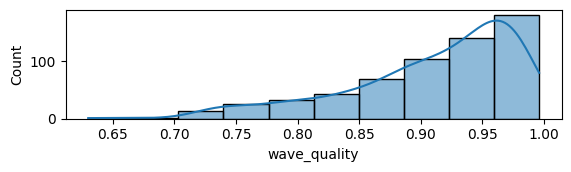

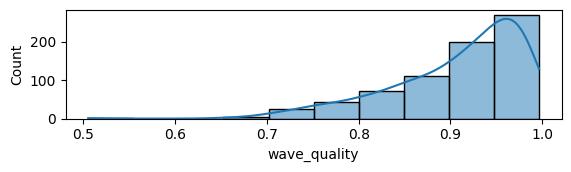

<Axes: xlabel='wave_quality', ylabel='Count'>

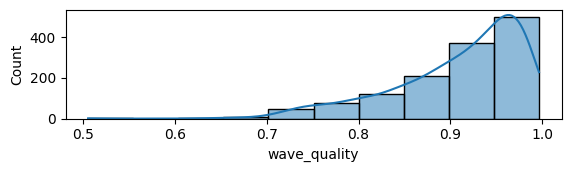

In [81]:
from matplotlib import figure

plt.subplot(3, 1, 1)  # 1行2列，第1个子图
sns.histplot(train_pos_dataset['wave_quality'], kde=True, bins=10)
plt.show()

plt.subplot(3, 1, 2)  # 1行2列，第1个子图
sns.histplot(train_neg_dataset['wave_quality'], kde=True, bins=10)
plt.show()

plt.subplot(3, 1, 3)  # 1行2列，第1个子图
sns.histplot(train_combined['wave_quality'], kde=True, bins=10)

In [82]:
wave_quality_threshold = 0.9

In [83]:
print(f"train pos sample shape: {train_pos_dataset.shape}")
print(f"train neg sample shape: {train_neg_dataset.shape}")

print(f"validation pos sample shape: {val_pos_dataset.shape}")
print(f"validation neg sample shape: {val_neg_dataset.shape}")

print(f"test pos sample shape: {test_neg_dataset.shape}")
print(f"test neg sample shape: {test_pos_dataset.shape}")

train pos sample shape: (611, 40)
train neg sample shape: (724, 40)
validation pos sample shape: (51, 40)
validation neg sample shape: (36, 40)
test pos sample shape: (66, 40)
test neg sample shape: (71, 40)


In [84]:
train_pos_dataset_final_filter = train_pos_dataset_final[train_pos_dataset_final['wave_quality'] >= wave_quality_threshold]
train_neg_dataset_final_filter = train_neg_dataset_final[train_neg_dataset_final['wave_quality'] >= wave_quality_threshold]

print(f"After quality filter, train positive sample count: {train_pos_dataset_final_filter.shape[0]}")
print(f"After quality filter, train negative sample count: {train_neg_dataset_final_filter.shape[0]}")


After quality filter, train positive sample count: 396
After quality filter, train negative sample count: 464


In [85]:
sample_folder = os.path.join(os.getcwd(), 'samples')
os.makedirs(sample_folder, exist_ok=True)

# 定义要保存的文件路径
train_pos_path = os.path.join(sample_folder, 'train_pos_dataset.pkl')
train_neg_path = os.path.join(sample_folder, 'train_neg_dataset.pkl')
val_pos_path = os.path.join(sample_folder, 'val_pos_dataset.pkl')
val_neg_path = os.path.join(sample_folder, 'val_neg_dataset.pkl')
test_pos_path = os.path.join(sample_folder, 'test_pos_dataset.pkl')
test_neg_path = os.path.join(sample_folder, 'test_neg_dataset.pkl')

# 保存 DataFrame 为 .pkl 文件
train_pos_dataset_final[train_pos_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(train_pos_path)
train_neg_dataset_final[train_neg_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(train_neg_path)

val_pos_dataset_final[val_pos_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(val_pos_path)
val_neg_dataset_final[val_neg_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(val_neg_path)

test_pos_dataset_final[test_pos_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(test_pos_path)
test_neg_dataset_final[test_neg_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(test_neg_path)

In [86]:
print(train_pos_dataset_final.columns)

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20',
       'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_HF', 'HRV_VHF',
       'HRV_TP', 'HRV_HFn', 'HRV_LnHF', 'wave_quality', 'label', 'id', 'age',
       'gender'],
      dtype='object')
